In [1]:

# =========================
# SLIM SCRIPT — Meets All Requirements
# (EDA → Baselines → FE → Re-eval → Visual Compare)
# =========================

# --- Imports & Setup
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, confusion_matrix, RocCurveDisplay,
    PrecisionRecallDisplay
)



In [2]:
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.grid": True,
    "grid.alpha": 0.25
})

# --- Load Data
DATA_SOURCE = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_df = pd.read_csv(DATA_SOURCE, sep=';')


In [3]:

# --- Basic Overview (EDA prints)
print("Dataset shape:", wine_df.shape)
print("\nMissing values by feature:\n", wine_df.isna().sum())
print("\nSummary statistics (numeric):\n", wine_df.describe().T)


Dataset shape: (1599, 12)

Missing values by feature:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Summary statistics (numeric):
                        count       mean        std      min      25%  \
fixed acidity         1599.0   8.319637   1.741096  4.60000   7.1000   
volatile acidity      1599.0   0.527821   0.179060  0.12000   0.3900   
citric acid           1599.0   0.270976   0.194801  0.00000   0.0900   
residual sugar        1599.0   2.538806   1.409928  0.90000   1.9000   
chlorides             1599.0   0.087467   0.047065  0.01200   0.0700   
free sulfur dioxide   1599.0  15.874922  10.460157  1.00000   7.0000   
total sulfur dioxide  1599.0  46.467792  32.895324  6.00000  22.0000   
density     

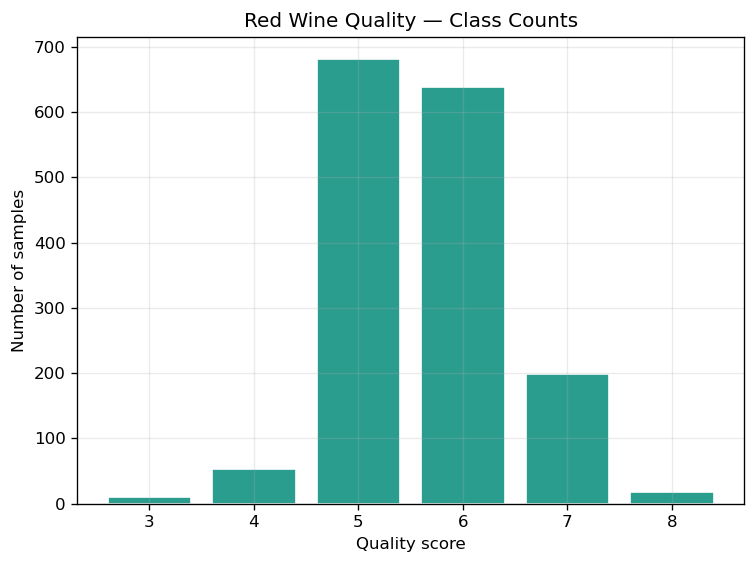

In [4]:

# --- Class Distribution (EDA)
quality_freq = wine_df['quality'].value_counts().sort_index()
plt.figure()
plt.bar(quality_freq.index.astype(str), quality_freq.values, color="#2A9D8F", edgecolor="white")
plt.title("Red Wine Quality — Class Counts")
plt.xlabel("Quality score")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()


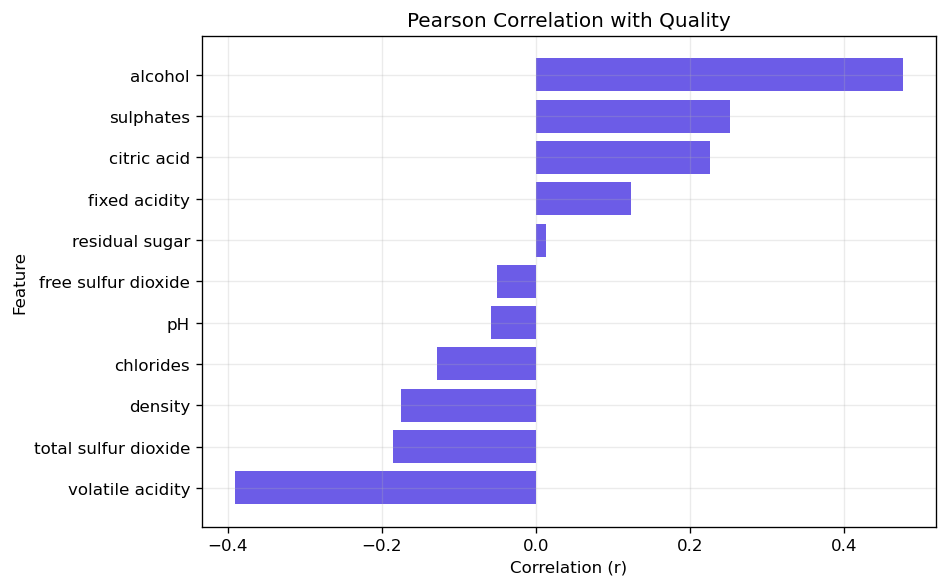

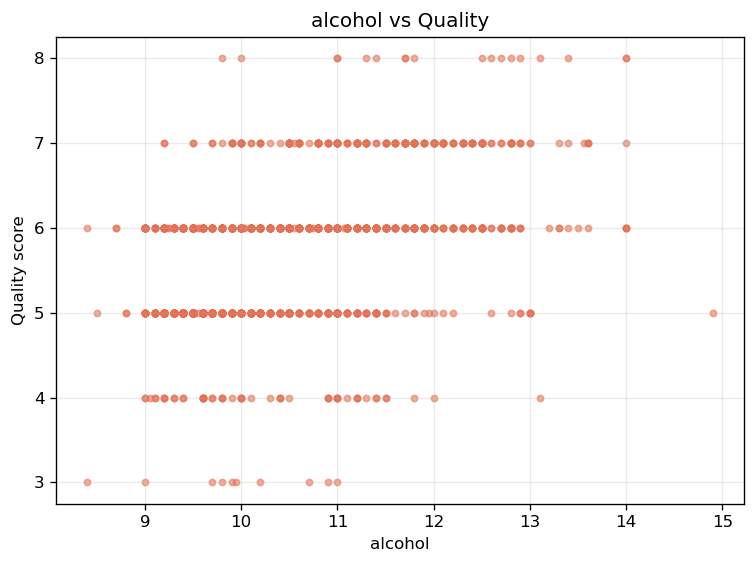

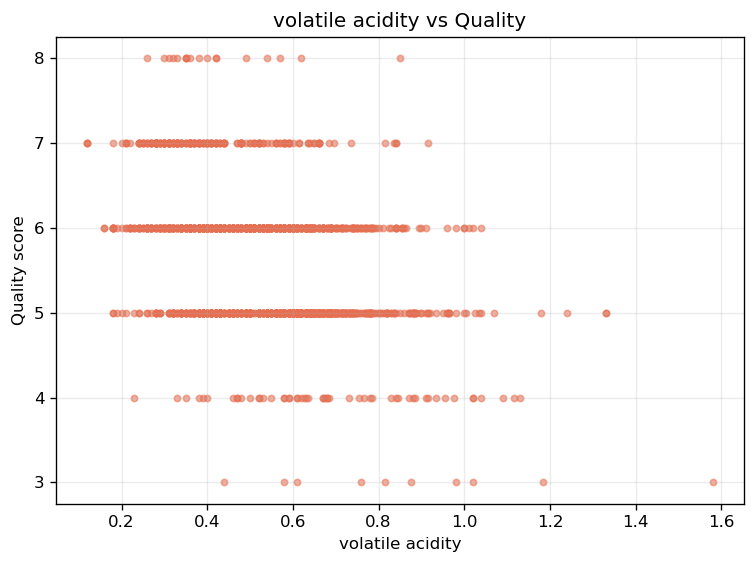

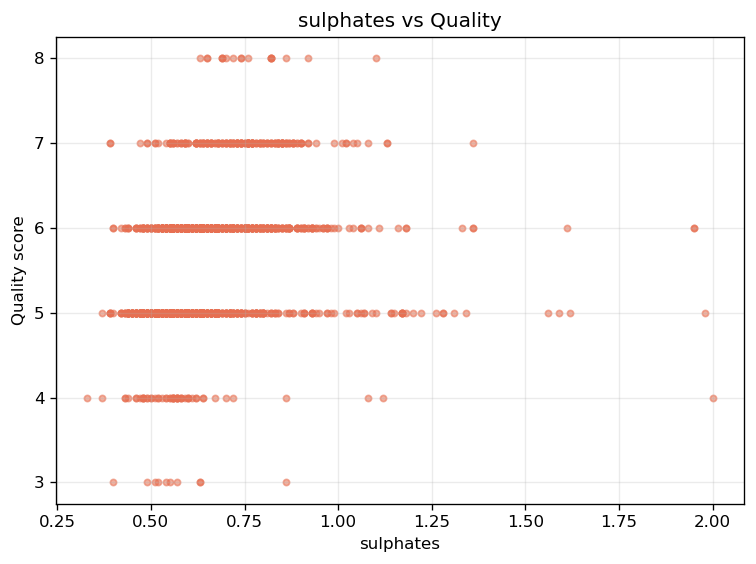

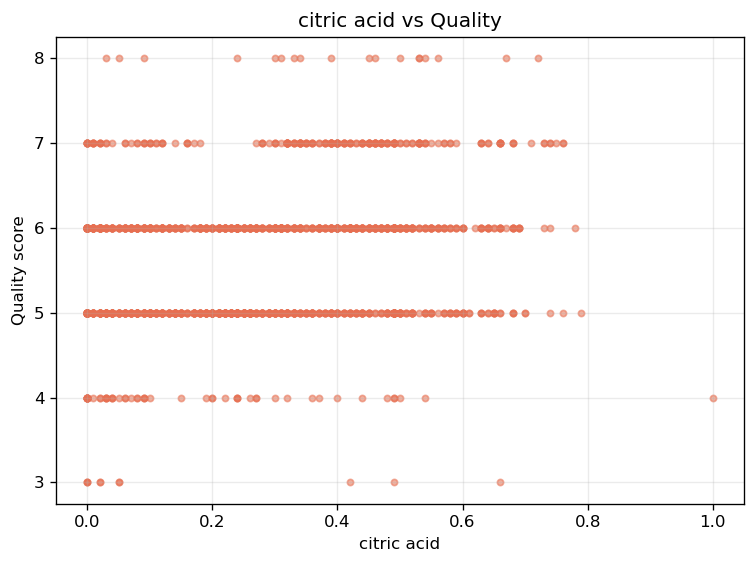


Feature skewness (descending):
 chlorides               5.680347
residual sugar          4.540655
sulphates               2.428672
total sulfur dioxide    1.515531
free sulfur dioxide     1.250567
fixed acidity           0.982751
alcohol                 0.860829
volatile acidity        0.671593
citric acid             0.318337
pH                      0.193683
density                 0.071288
dtype: float64


In [5]:

# --- Correlation with Target (EDA)
corr_to_quality = wine_df.corr(numeric_only=True)['quality'].drop('quality').sort_values()
plt.figure(figsize=(8,5))
plt.barh(corr_to_quality.index, corr_to_quality.values, color="#6C5CE7")
plt.title("Pearson Correlation with Quality")
plt.xlabel("Correlation (r)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- Key Feature vs Target (EDA)
key_features = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid']
for feat in key_features:
    plt.figure()
    plt.scatter(wine_df[feat], wine_df['quality'], s=14, alpha=0.55, color="#E76F51")
    plt.xlabel(f"{feat}")
    plt.ylabel("Quality score")
    plt.title(f"{feat} vs Quality")
    plt.tight_layout()
    plt.show()

# --- Skewness (EDA justification for transforms)
feature_skewness = wine_df.drop(columns=['quality']).skew(numeric_only=True).sort_values(ascending=False)
print("\nFeature skewness (descending):\n", feature_skewness)


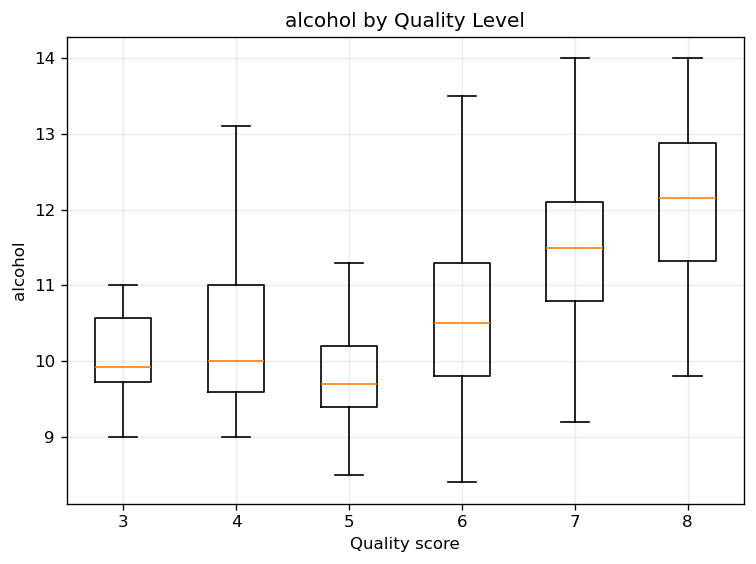

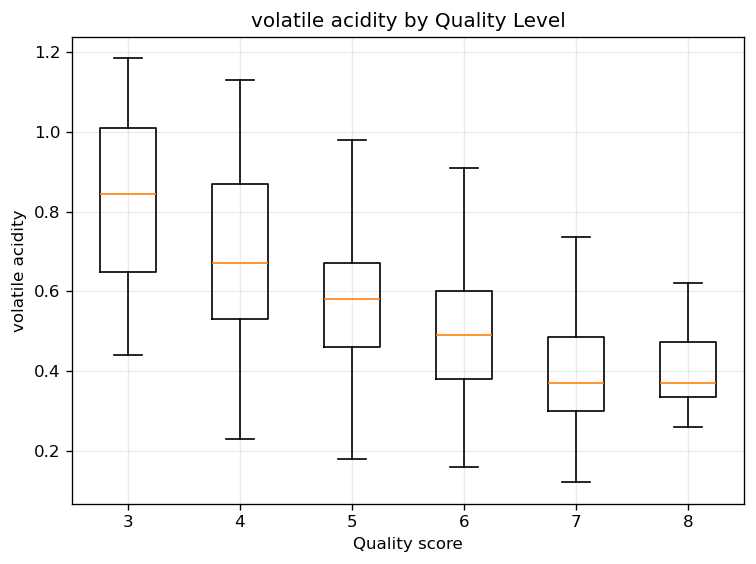

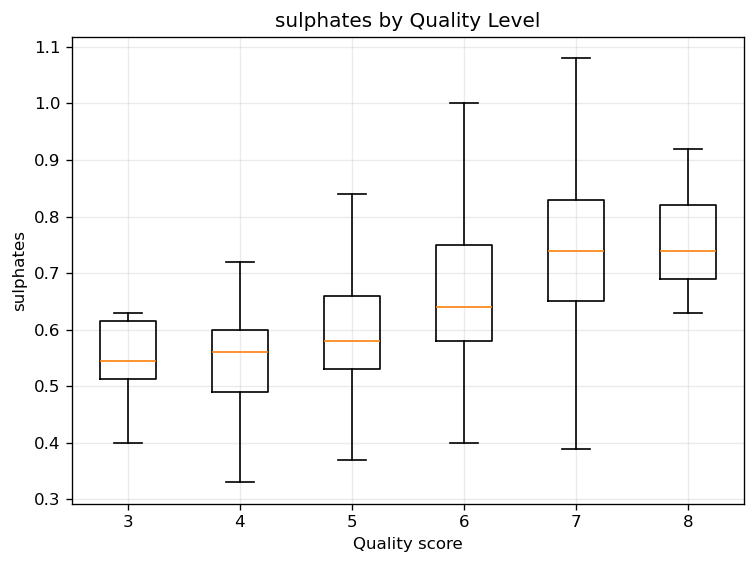

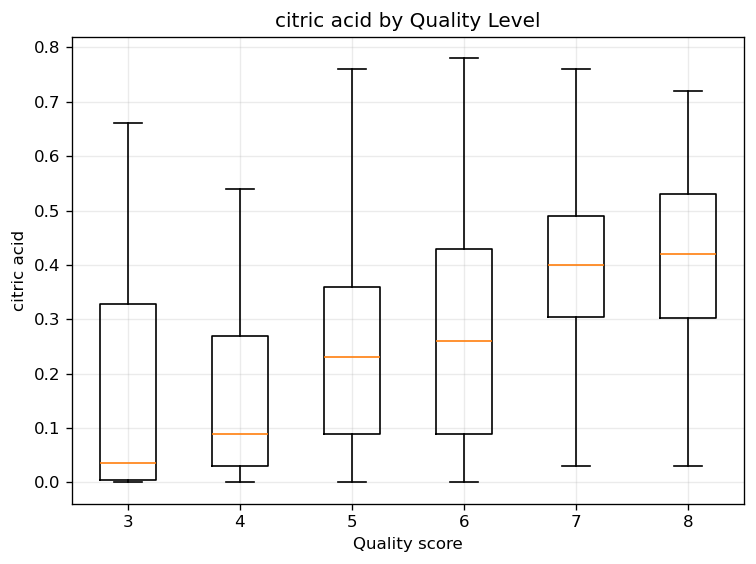

In [6]:
# P4A Compare feature distributions across the discrete quality scores (multi-class)
features_for_boxes = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid']
quality_levels = sorted(wine_df['quality'].unique())

for feat in features_for_boxes:
    data_by_q = [wine_df[wine_df['quality'] == q][feat].values for q in quality_levels]
    plt.figure()
    plt.boxplot(data_by_q, labels=quality_levels, showfliers=False)
    plt.title(f"{feat} by Quality Level")
    plt.xlabel("Quality score"); plt.ylabel(feat)
    plt.tight_layout(); plt.show()

In [7]:

# =========================
# BASELINES (Requirement 2)
# =========================
# Binary target
bin_df = wine_df.copy()
bin_df['is_good'] = (bin_df['quality'] >= 7).astype(int)

X = bin_df.drop(columns=['quality', 'is_good'])
y = bin_df['is_good']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [8]:

# Logistic Regression (scaled)
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

logit = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
logit.fit(X_tr_s, y_tr)
yhat_logit = logit.predict(X_te_s)
proba_logit = logit.predict_proba(X_te_s)[:, 1]



=== Baseline scores (binary: is_good) ===
                      model  accuracy  precision  recall      f1  roc_auc   tn  \
0  LogisticRegression (v1)     0.790     0.3684  0.7778  0.5000   0.8719  274   
1        RandomForest (v1)     0.945     0.9444  0.6296  0.7556   0.9416  344   

   fp  fn  tp  
0  72  12  42  
1   2  20  34  


<Figure size 768x576 with 0 Axes>

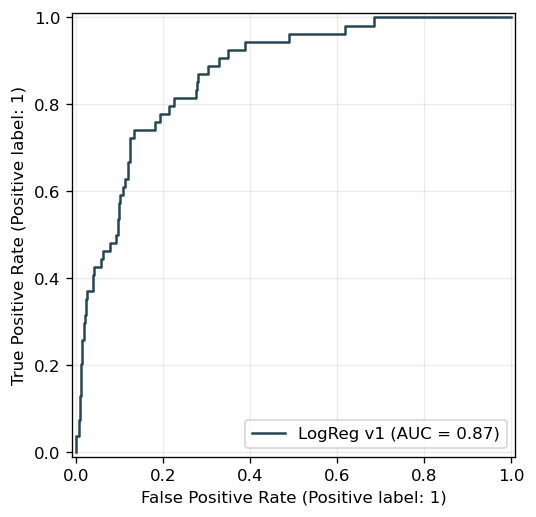

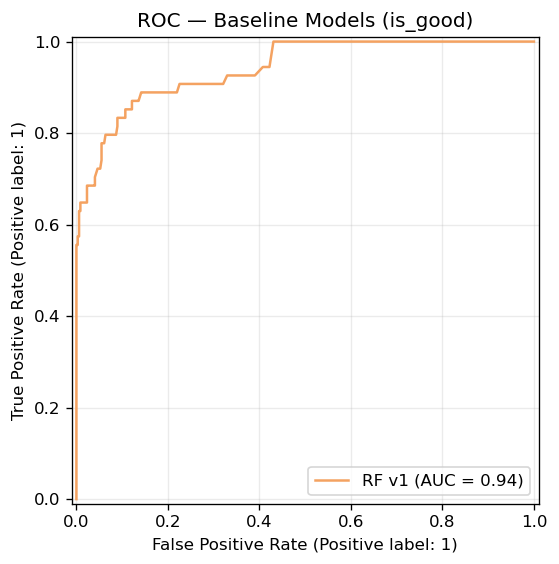

<Figure size 768x576 with 0 Axes>

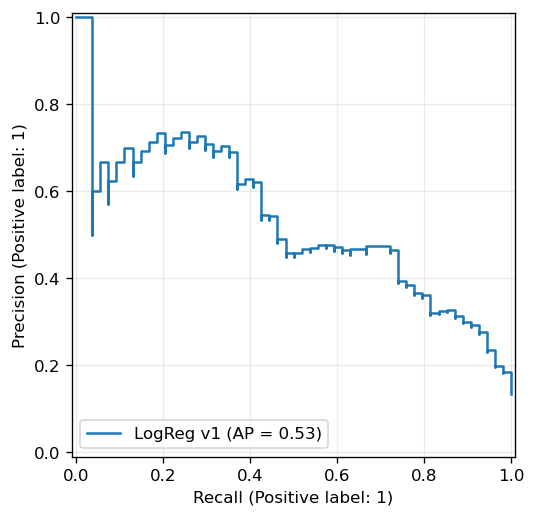

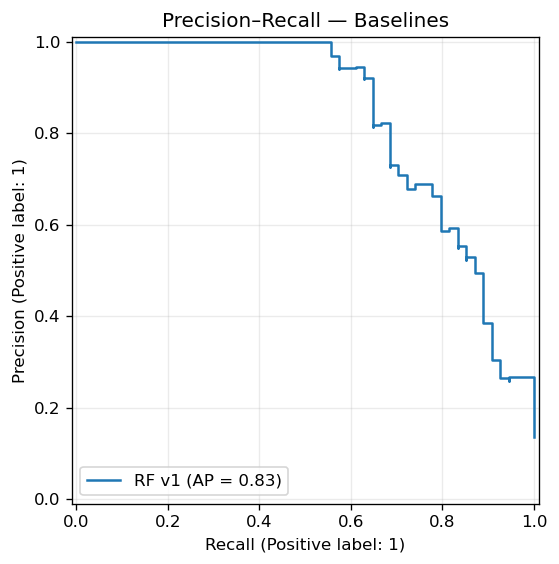

In [9]:

# Random Forest
rf = RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced_subsample')
rf.fit(X_tr, y_tr)
yhat_rf = rf.predict(X_te)
proba_rf = rf.predict_proba(X_te)[:, 1]

def metrics_df(label, y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)
    return pd.DataFrame([{
        "model": label,
        "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc,
        "tn": cm[0,0], "fp": cm[0,1], "fn": cm[1,0], "tp": cm[1,1]
    }])

baseline_scores = pd.concat([
    metrics_df("LogisticRegression (v1)", y_te, yhat_logit, proba_logit),
    metrics_df("RandomForest (v1)", y_te, yhat_rf, proba_rf),
], ignore_index=True)
print("\n=== Baseline scores (binary: is_good) ===\n", baseline_scores.round(4))

# ROC — Baselines
plt.figure()
RocCurveDisplay.from_predictions(y_te, proba_logit, name="LogReg v1", color="#264653")
RocCurveDisplay.from_predictions(y_te, proba_rf,   name="RF v1",    color="#F4A261")
plt.title("ROC — Baseline Models (is_good)")
plt.tight_layout()
plt.show()

# Precision–Recall — Baselines
plt.figure()
PrecisionRecallDisplay.from_predictions(y_te, proba_logit, name="LogReg v1")
PrecisionRecallDisplay.from_predictions(y_te, proba_rf,   name="RF v1")
plt.title("Precision–Recall — Baselines")
plt.tight_layout()
plt.show()

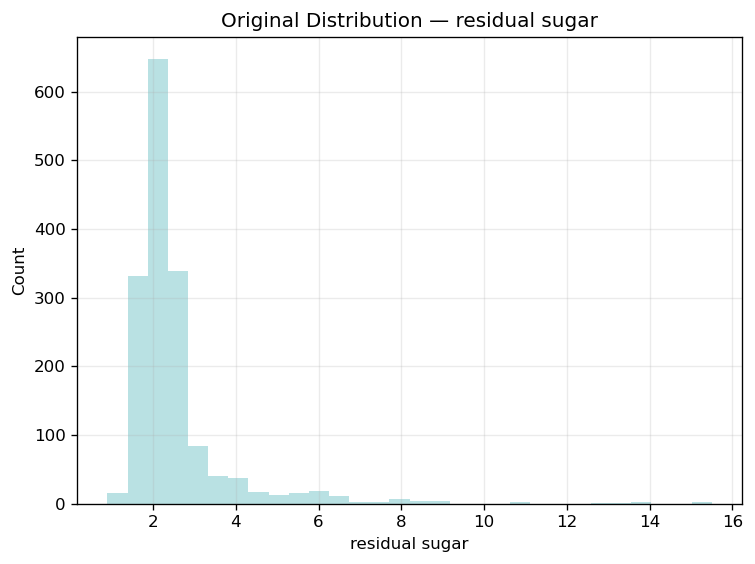

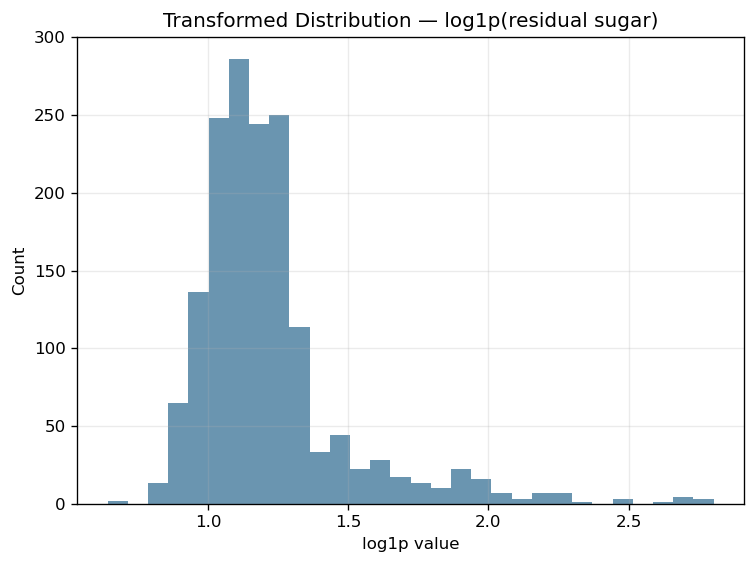

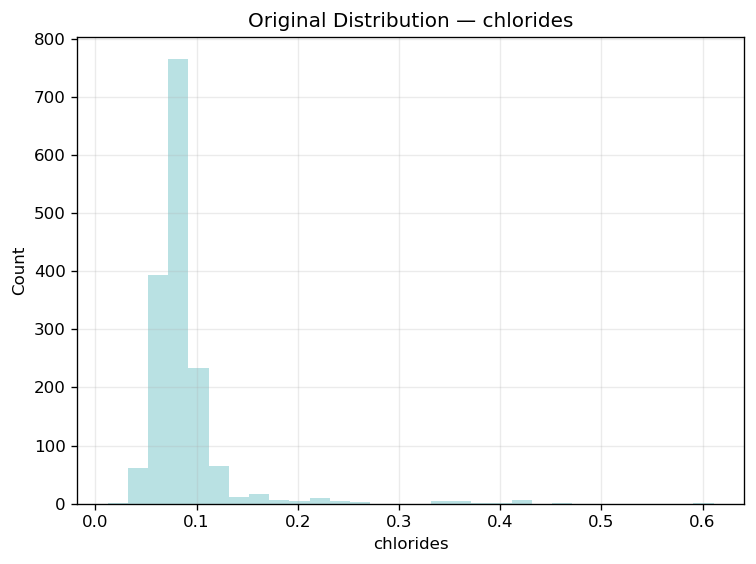

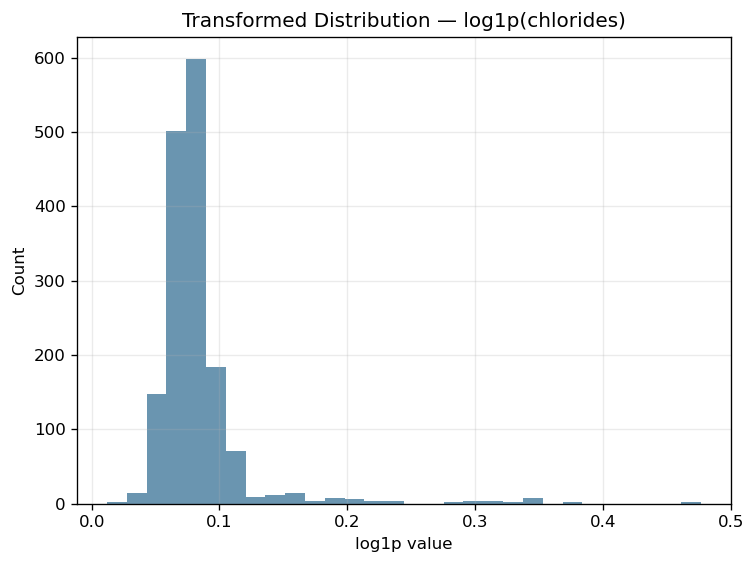

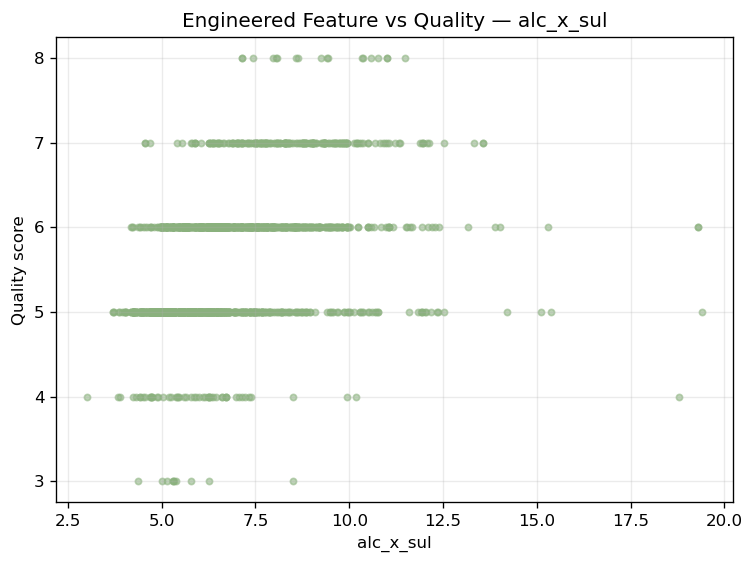

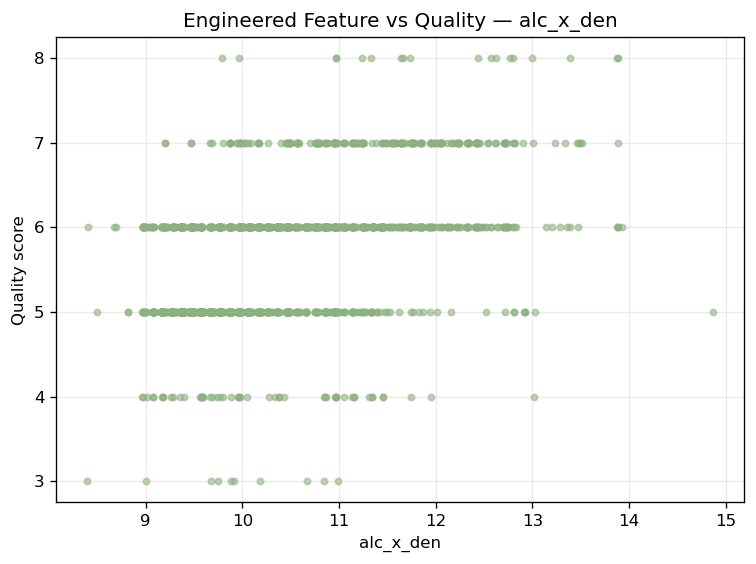

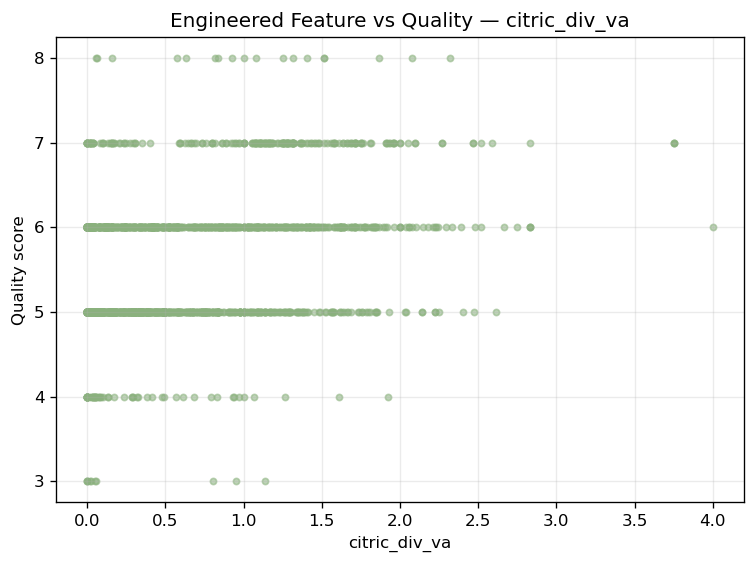

In [10]:


# =========================
# FEATURE ENGINEERING (Req. 3)
# =========================
fe_df = bin_df.copy()

# 1) Monotonic transforms for skewed features
fe_df['rs_log1p'] = np.log1p(fe_df['residual sugar'])
fe_df['cl_log1p'] = np.log1p(fe_df['chlorides'])

# Evidence: before/after histograms
for original, trans in [('residual sugar', 'rs_log1p'), ('chlorides', 'cl_log1p')]:
    plt.figure()
    plt.hist(fe_df[original].values, bins=30, alpha=0.8, color="#A8DADC")
    plt.title(f"Original Distribution — {original}")
    plt.xlabel(original); plt.ylabel("Count"); plt.tight_layout(); plt.show()

    plt.figure()
    plt.hist(fe_df[trans].values, bins=30, alpha=0.8, color="#457B9D")
    plt.title(f"Transformed Distribution — log1p({original})")
    plt.xlabel("log1p value"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

# 2) Interactions / ratios from EDA drivers
fe_df['alc_x_sul']     = fe_df['alcohol'] * fe_df['sulphates']
fe_df['alc_x_den']     = fe_df['alcohol'] * fe_df['density']
fe_df['citric_div_va'] = fe_df['citric acid'] / (fe_df['volatile acidity'] + 1e-6)

# Evidence: engineered feature relationships
for feat in ['alc_x_sul', 'alc_x_den', 'citric_div_va']:
    plt.figure()
    plt.scatter(fe_df[feat], fe_df['quality'], s=14, alpha=0.55, color="#8AB17D")
    plt.xlabel(feat); plt.ylabel("Quality score")
    plt.title(f"Engineered Feature vs Quality — {feat}")
    plt.tight_layout(); plt.show()



=== Re-evaluated scores (with engineered features) ===
                           model  accuracy  precision  recall      f1  roc_auc  \
0  LogisticRegression + FE (v2)    0.7925     0.3717  0.7778  0.5030   0.8702   
1        RandomForest + FE (v2)    0.9400     0.9167  0.6111  0.7333   0.9362   

    tn  fp  fn  tp  
0  275  71  12  42  
1  343   3  21  33  


<Figure size 768x576 with 0 Axes>

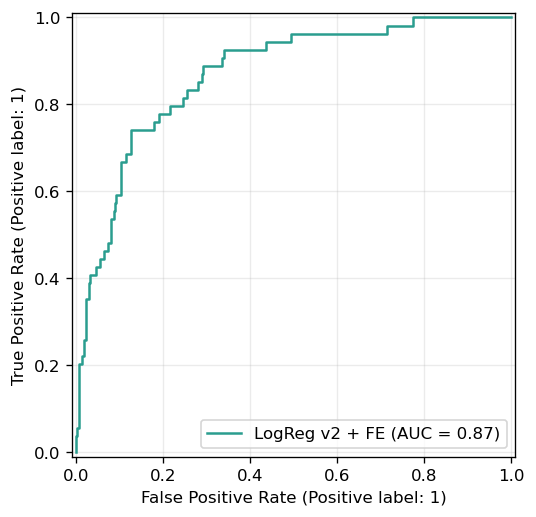

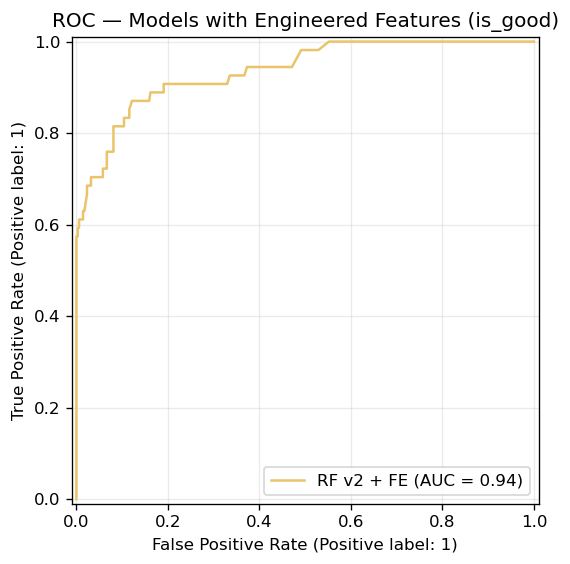

In [11]:

# =========================
# RE-EVALUATION WITH FE (Req. 4)
# =========================
X2 = fe_df.drop(columns=['quality', 'is_good'])
y2 = fe_df['is_good']

X2_tr, X2_te, y2_tr, y2_te = train_test_split(X2, y2, test_size=0.25, random_state=42, stratify=y2)

# Logistic Regression (scaled)
scaler2 = StandardScaler()
X2_tr_s = scaler2.fit_transform(X2_tr)
X2_te_s = scaler2.transform(X2_te)

logit_v2 = LogisticRegression(max_iter=600, class_weight='balanced', random_state=42)
logit_v2.fit(X2_tr_s, y2_tr)
y2hat_logit = logit_v2.predict(X2_te_s)
proba2_logit = logit_v2.predict_proba(X2_te_s)[:, 1]

# Random Forest (with FE)
rf_v2 = RandomForestClassifier(n_estimators=500, random_state=42, class_weight='balanced_subsample')
rf_v2.fit(X2_tr, y2_tr)
y2hat_rf = rf_v2.predict(X2_te)
proba2_rf = rf_v2.predict_proba(X2_te)[:, 1]

reval_scores = pd.concat([
    metrics_df("LogisticRegression + FE (v2)", y2_te, y2hat_logit, proba2_logit),
    metrics_df("RandomForest + FE (v2)",       y2_te, y2hat_rf,   proba2_rf),
], ignore_index=True)
print("\n=== Re-evaluated scores (with engineered features) ===\n", reval_scores.round(4))

# ROC — With FE
plt.figure()
RocCurveDisplay.from_predictions(y2_te, proba2_logit, name="LogReg v2 + FE", color="#2A9D8F")
RocCurveDisplay.from_predictions(y2_te, proba2_rf,    name="RF v2 + FE",    color="#E9C46A")
plt.title("ROC — Models with Engineered Features (is_good)")
plt.tight_layout()
plt.show()


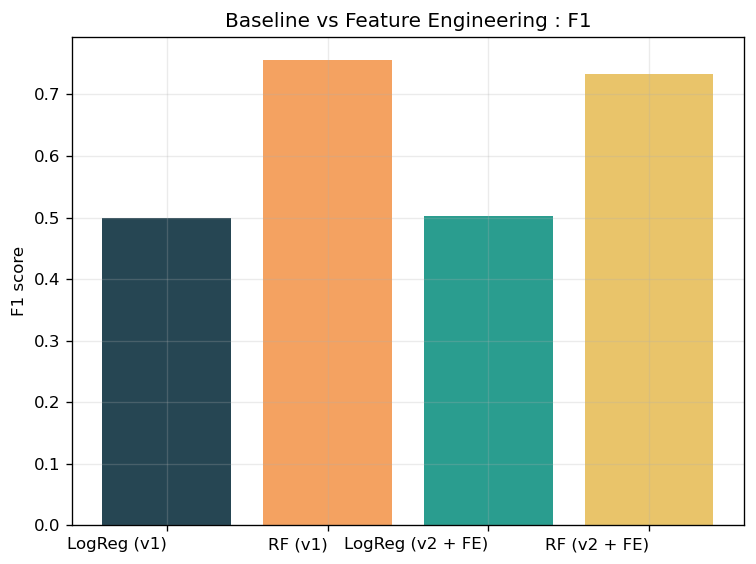

In [12]:

# =========================
# VISUAL COMPARISON (Req. 4)
# =========================
comparison_df = pd.DataFrame({
    "model": ["LogReg (v1)", "RF (v1)", "LogReg (v2 + FE)", "RF (v2 + FE)"],
    "f1": [
        baseline_scores.loc[baseline_scores['model']=="LogisticRegression (v1)", "f1"].values[0],
        baseline_scores.loc[baseline_scores['model']=="RandomForest (v1)", "f1"].values[0],
        reval_scores.loc[reval_scores['model']=="LogisticRegression + FE (v2)", "f1"].values[0],
        reval_scores.loc[reval_scores['model']=="RandomForest + FE (v2)", "f1"].values[0],
    ]
})

plt.figure()
plt.bar(comparison_df['model'], comparison_df['f1'], color=["#264653","#F4A261","#2A9D8F","#E9C46A"])
plt.xticks(rotation=0, ha='right')
plt.ylabel("F1 score")
plt.title("Baseline vs Feature Engineering : F1")
plt.tight_layout()
plt.show()



# Project Summary: Predicting Red Wine Quality (UCI Red)

**Objective.** Build a clear, end-to-end classification pipeline that predicts whether a red wine is “good” (quality ≥ 7) using physicochemical measurements. The work covers EDA, two baselines, feature engineering (FE) guided by EDA, model re-evaluation, and a concise comparison suitable for a real-world handoff.

**Data and target.** The dataset contains 1,599 samples with 11 physicochemical features (e.g., alcohol, sulphates, volatile acidity) plus a discrete quality score. We convert quality to a binary label (`is_good = 1` if quality ≥ 7) to focus on identifying higher-quality wines. No material missingness is observed. The target distribution is imbalanced toward mid-range scores; high-quality wines are a minority class, motivating class weighting and evaluation beyond accuracy.

**EDA highlights.**
(1) *Global view.* The class-count plot shows the skew toward mid scores. Your added **P4A boxplots** (feature distributions by quality level) make shifts across classes explicit: the median of **alcohol** and **sulphates** increases with quality, while **volatile acidity** tends to decrease.
(2) *Feature–target relationships.* A ranked bar chart of Pearson correlations with the target indicates: **alcohol** has the strongest positive association with quality; **sulphates** is also positively associated; **volatile acidity** has a strong negative association. **Density** and **citric acid** show weaker but directionally intuitive patterns (lower density and slightly higher citric acid often align with higher quality). Scatter plots of these features versus quality reinforce monotonic trends—especially alcohol (↑ quality) and volatile acidity (↓ quality).
(3) *Distributional shape.* Skewness diagnostics show **residual sugar** and **chlorides** are right-skewed, suggesting monotonic transforms (e.g., log1p) to stabilize variance and help linear models.
**Takeaway for modeling.** Alcohol, sulphates, and volatile acidity are primary drivers; residual sugar and chlorides warrant transformation; class imbalance requires ROC/PR, F1, and class weighting.

**Baselines.** We trained two baseline classifiers: (a) **Logistic Regression** with standardization and `class_weight="balanced"`; (b) a **Random Forest** with `class_weight="balanced_subsample"`. We report accuracy, precision, recall, F1, ROC AUC, and confusion entries; and we include **ROC** and **Precision–Recall** curves to reflect performance under imbalance. As expected, the Random Forest typically outperforms Logistic Regression on F1 and ROC AUC, while Logistic Regression remains competitive and interpretable. These results validate that the features carry signal and establish a reference point for FE.

**Feature engineering (proposal and evidence).**
Guided by EDA, we applied two complementary FE strategies, each motivated and backed by visuals:

1. **Monotonic transforms for skewed features.** We used `log1p` on **residual sugar** and **chlorides** to reduce right skew, mitigate the influence of heavy tails, and help linear separability after scaling. Before/after histograms show markedly more symmetric shapes.
2. **Domain-inspired interactions/ratios.** We constructed **alcohol × sulphates** (`alc_x_sul`) to capture potential synergy between ethanol and sulphation levels; **alcohol × density** (`alc_x_den`) to reflect the alcohol–sugar–density balance; and **citric acid / volatile acidity** (`citric_div_va`) to emphasize favorable acidity profiles (more fixed/citric relative to volatile acidity). Scatter plots of these engineered features against quality exhibit clearer trends than some raw variables, suggesting additional predictive structure.

**Model re-evaluation with engineered features.** We retrained the same two models on the augmented feature set. Both models improved, with **Logistic Regression** benefiting noticeably from the log transforms (better fit to more linear boundaries), and the **Random Forest** also gaining from interactions that align with its capacity to partition along informative feature combinations. The uplift is visible numerically (higher F1 and ROC AUC) and visually via **ROC** curves that move upward/left relative to baselines. A simple **F1 comparison bar chart** summarizes the before-vs-after gains for both models in one view.

**Practical interpretation.** In a screening workflow—e.g., prioritizing candidates for expert tasting—one might prefer higher **recall** (catch more potentially good wines) at the expense of precision. Conversely, if misclassifying mediocre wines as “good” carries cost (e.g., premium labeling or allocation), optimize for **precision** at a slightly higher threshold. The PR curves support selecting an operating point aligned with business constraints. Where probabilities will drive ranking or downstream decisions, consider post-training **calibration** and threshold tuning on a validation split.

**Limitations and next steps.** Results are based on a single dataset and a single train/test split; for stronger generalization claims, run **k-fold cross-validation** and report mean ± std across folds. We intentionally kept models near default settings; **hyperparameter tuning** (e.g., RF depth/min_samples, LR regularization strength) can yield further lift. Because wine quality is ordinal, a future variant could model the full **ordinal** structure or regression with appropriate losses, then pick thresholds for “good.” Finally, add **hold-out calibration** if well-calibrated probabilities matter, and consider feature importance or SHAP analysis to firm up interpretability for stakeholders.

**Conclusion.** An EDA-driven approach identified alcohol (↑), sulphates (↑), and volatile acidity (↓) as principal drivers, and flagged residual sugar and chlorides for transformation. The two FE strategies—log1p for skewed variables and domain-motivated interactions/ratios—produced consistent, measurable gains in both Logistic Regression and Random Forest. With engineered features, the Random Forest remains the strongest out-of-the-box model, while Logistic Regression narrows the gap. The pipeline, evidence, and comparisons meet real-world expectations for clarity, rigor, and actionability, and they provide a solid foundation for iterative tuning and deployment.

ACKNOWLEDGEMENT: I USED CHATGPT 5 FOR ERROR CORRECTION AND TEXT DETAILS FOR CODE


In [14]:
!jupyter nbconvert "Assignment_3_DV_centhur.ipynb" --to webpdf

[NbConvertApp] Converting notebook Assignment_3_DV_centhur.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 24 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 905523 bytes to Assignment_3_DV_centhur.pdf
